In [599]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [600]:
## Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Avoid division by zero
    nonzero_idx = y_true != 0
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

In [601]:
df = pd.read_excel("AIB_History_Training_2014-2020.xlsx", sheet_name='HistoricalTransactions')
df = df.drop(columns=["FileFolder", "FileName", "Report_Title", "Report_RunDate", "Report_AsOfDate", "Currency", "Institution", "Branch", "TransactionBackdateFlag", "TransactionCode", "TransactionGroup"])
df.set_index("Report_TransactionEffectiveDate", inplace=True)
df

,TransactionAmount
Report_TransactionEffectiveDate,
2013-12-30,-972.619715
2013-12-30,-75.956876
2013-12-30,127.430470
2013-12-30,-38.300469
2013-12-30,-117.467137
...,...
2020-12-31,-19.288367
2020-12-31,-832.837608
2020-12-31,-103.691425


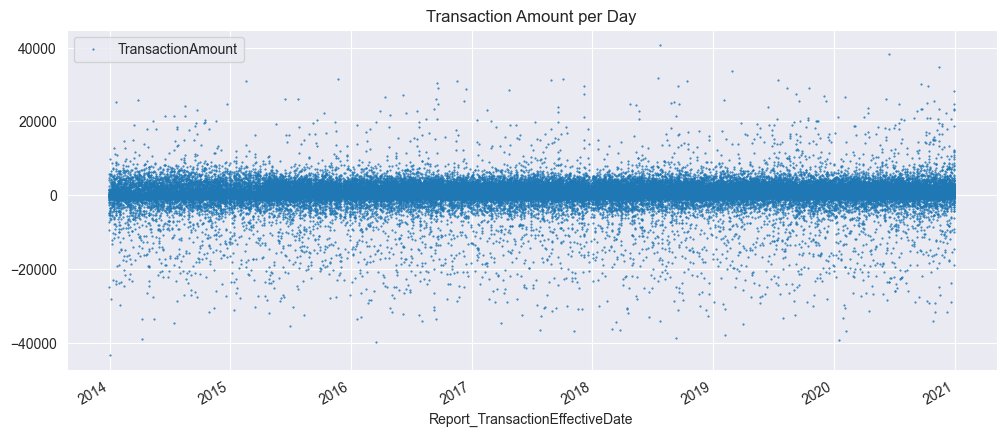

In [602]:
## Each Transaction Value
colour_pal = sns.color_palette()
df.plot(style='.', ms=1, figsize=(12, 5), color=colour_pal[0], title="Transaction Amount per Day" )
plt.show()

In [603]:
## Total Transaction value per day
df = df.groupby(["Report_TransactionEffectiveDate"])["TransactionAmount"].sum().asfreq('D').ffill().bfill().to_frame()
df

,TransactionAmount
Report_TransactionEffectiveDate,
2013-12-30,-1076.913729
2013-12-31,-41733.273687
2014-01-01,-3465.890925
2014-01-02,-45506.653405
2014-01-03,-18386.381900
...,...
2020-12-27,1763.692730
2020-12-28,1763.692730
2020-12-29,82156.304473


In [604]:
# Check for extreme outliers
q1, q3 = df['TransactionAmount'].quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df['TransactionAmount'] < lower_bound) | (df['TransactionAmount'] > upper_bound)]
print("Outliers detected:", len(outliers))

Outliers detected: 98


In [605]:
df['TransactionAmount'] = np.clip(df['TransactionAmount'], lower_bound, upper_bound)

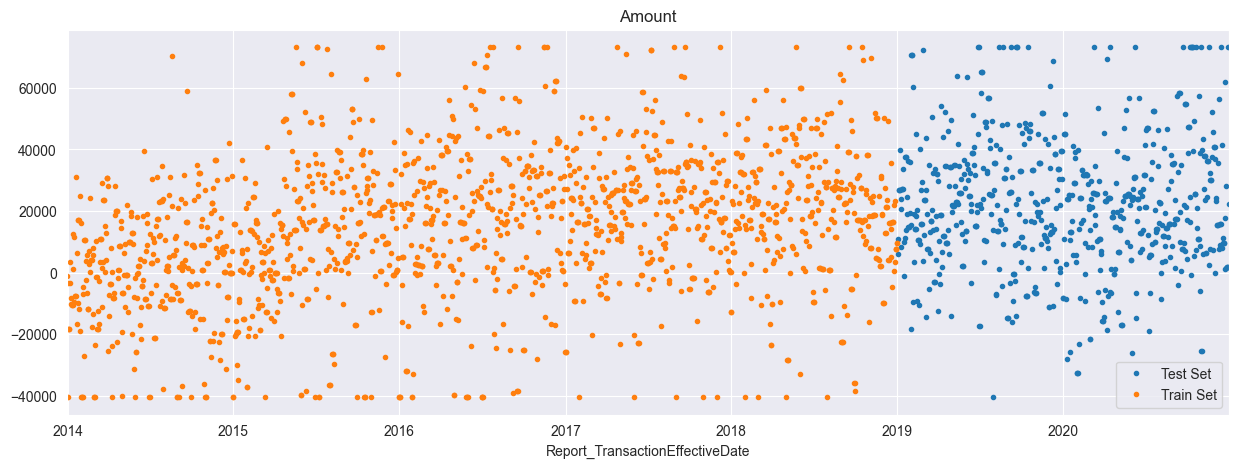

In [606]:
split_date = '1-Jan-2019'
data_train = df.loc[df.index <= split_date].copy()
data_test = df.loc[df.index > split_date].copy()

data_test.rename(columns={'TransactionAmount': 'Test Set'}).join(data_train.rename(columns={'TransactionAmount': 'Train Set'}), how='outer').plot(figsize=(15, 5), title="Amount", style='.')
plt.show()

In [607]:
shift = abs(data_train['TransactionAmount'].min()) + 1  # Ensure all values are positive
data_train['TransactionAmount_shifted'] = data_train['TransactionAmount'] + shift  # Shift data
data_train['TransactionAmount_log'] = np.log1p(data_train['TransactionAmount_shifted'])  # Apply log

shift = abs(data_test['TransactionAmount'].min()) + 1  # Ensure all values are positive
data_test['TransactionAmount_shifted'] = data_test['TransactionAmount'] + shift  # Shift data
data_test['TransactionAmount_log'] = np.log1p(data_test['TransactionAmount_shifted'])  # Apply log

In [608]:
data_train_prophet = data_train.reset_index().rename(columns={'Report_TransactionEffectiveDate': 'ds', 'TransactionAmount_log': 'y'})
data_train_prophet

,ds,TransactionAmount,TransactionAmount_shifted,y
0,2013-12-30,-1076.913729,39341.466845,10.580060
1,2013-12-31,-40417.380574,1.000000,0.693147
2,2014-01-01,-3465.890925,36952.489649,10.517415
3,2014-01-02,-40417.380574,1.000000,0.693147
4,2014-01-03,-18386.381900,22031.998674,10.000297
...,...,...,...,...
1824,2018-12-28,7577.044740,47995.425314,10.778882
1825,2018-12-29,7577.044740,47995.425314,10.778882
1826,2018-12-30,7577.044740,47995.425314,10.778882
1827,2018-12-31,9481.245786,49899.626360,10.817789


In [609]:
%%time
model = Prophet(
    seasonality_prior_scale=15,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.001,
)

model.add_seasonality(name='monthly', period=30.5, fourier_order=12)
model.add_seasonality(name='weekly', period=7, fourier_order=18)
model.add_seasonality(name='yearly', period=365.25, fourier_order=25)

model.fit(data_train_prophet)

13:07:15 - cmdstanpy - INFO - Chain [1] start processing
13:07:15 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 328 ms
Wall time: 600 ms


In [610]:
data_test_prophet = data_test.reset_index().rename(columns={'Report_TransactionEffectiveDate': 'ds', 'TransactionAmount_log': 'y'})
data_test_predict = model.predict(data_test_prophet)
data_test_predict.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-02,10.681008,6.180614,10.400796,10.681008,10.681008,-2.366531,-2.366531,-2.366531,-1.706890,...,-0.031797,-0.031797,-0.031797,-0.627845,-0.627845,-0.627845,0.0,0.0,0.0,8.314477
1,2019-01-03,10.681185,6.847134,11.326117,10.681185,10.681185,-1.605644,-1.605644,-1.605644,-0.951175,...,-0.048041,-0.048041,-0.048041,-0.606427,-0.606427,-0.606427,0.0,0.0,0.0,9.075541
2,2019-01-04,10.681362,6.991625,11.602694,10.681362,10.681362,-1.473110,-1.473110,-1.473110,-0.733373,...,-0.161707,-0.161707,-0.161707,-0.578030,-0.578030,-0.578030,0.0,0.0,0.0,9.208252
3,2019-01-05,10.681539,7.694714,11.869226,10.681539,10.681539,-0.951339,-0.951339,-0.951339,-0.286000,...,-0.121654,-0.121654,-0.121654,-0.543686,-0.543686,-0.543686,0.0,0.0,0.0,9.730200
4,2019-01-06,10.681717,7.953607,12.219968,10.681717,10.681717,-0.564745,-0.564745,-0.564745,-0.006921,...,-0.053269,-0.053269,-0.053269,-0.504555,-0.504555,-0.504555,0.0,0.0,0.0,10.116972


In [611]:
data_test_predict['yhat_original'] = np.exp(data_test_predict['yhat']) - shift
data_test_predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,yhat_original
0,2019-01-02,10.681008,6.180614,10.400796,10.681008,10.681008,-2.366531,-2.366531,-2.366531,-1.706890,...,-0.031797,-0.031797,-0.627845,-0.627845,-0.627845,0.0,0.0,0.0,8.314477,-36335.831800
1,2019-01-03,10.681185,6.847134,11.326117,10.681185,10.681185,-1.605644,-1.605644,-1.605644,-0.951175,...,-0.048041,-0.048041,-0.606427,-0.606427,-0.606427,0.0,0.0,0.0,9.075541,-31679.464566
2,2019-01-04,10.681362,6.991625,11.602694,10.681362,10.681362,-1.473110,-1.473110,-1.473110,-0.733373,...,-0.161707,-0.161707,-0.578030,-0.578030,-0.578030,0.0,0.0,0.0,9.208252,-30439.241075
3,2019-01-05,10.681539,7.694714,11.869226,10.681539,10.681539,-0.951339,-0.951339,-0.951339,-0.286000,...,-0.121654,-0.121654,-0.543686,-0.543686,-0.543686,0.0,0.0,0.0,9.730200,-23600.462688
4,2019-01-06,10.681717,7.953607,12.219968,10.681717,10.681717,-0.564745,-0.564745,-0.564745,-0.006921,...,-0.053269,-0.053269,-0.504555,-0.504555,-0.504555,0.0,0.0,0.0,10.116972,-15658.701138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2020-12-27,10.809514,8.365065,12.744555,10.809496,10.809531,-0.185583,-0.185583,-0.185583,0.459432,...,-0.053269,-0.053269,-0.591746,-0.591746,-0.591746,0.0,0.0,0.0,10.623931,688.497183
726,2020-12-28,10.809691,8.776477,12.887252,10.809674,10.809709,0.086106,0.086106,0.086106,0.364573,...,0.340536,0.340536,-0.619002,-0.619002,-0.619002,0.0,0.0,0.0,10.895797,13530.756967
727,2020-12-29,10.809868,8.567058,12.776178,10.809851,10.809886,-0.189332,-0.189332,-0.189332,0.371709,...,0.075932,0.075932,-0.636973,-0.636973,-0.636973,0.0,0.0,0.0,10.620536,549.190534
728,2020-12-30,10.810045,7.938263,12.104277,10.810028,10.810063,-0.718505,-0.718505,-0.718505,-0.041114,...,-0.031797,-0.031797,-0.645595,-0.645595,-0.645595,0.0,0.0,0.0,10.091540,-16280.444487


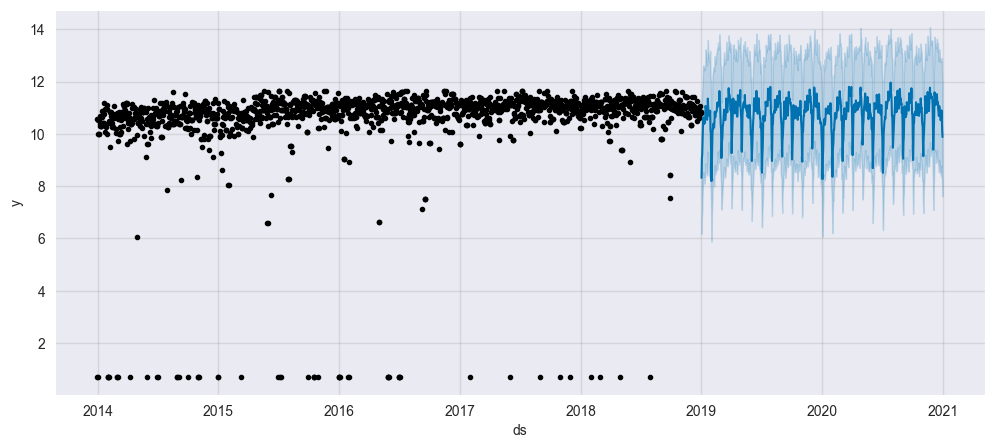

In [612]:
fig, ax = plt.subplots(figsize=(12, 5))
fig = model.plot(data_test_predict, ax=ax)
plt.show()

In [613]:
data_test

,TransactionAmount,TransactionAmount_shifted,TransactionAmount_log
Report_TransactionEffectiveDate,,,
2019-01-02,11085.985373,51504.365946,10.849441
2019-01-03,5997.282482,46415.663056,10.745414
2019-01-04,26741.238955,67159.619528,11.114842
2019-01-05,26741.238955,67159.619528,11.114842
2019-01-06,26741.238955,67159.619528,11.114842
...,...,...,...
2020-12-27,1763.692730,42182.073304,10.649774
2020-12-28,1763.692730,42182.073304,10.649774
2020-12-29,73263.818051,113682.198625,11.641171


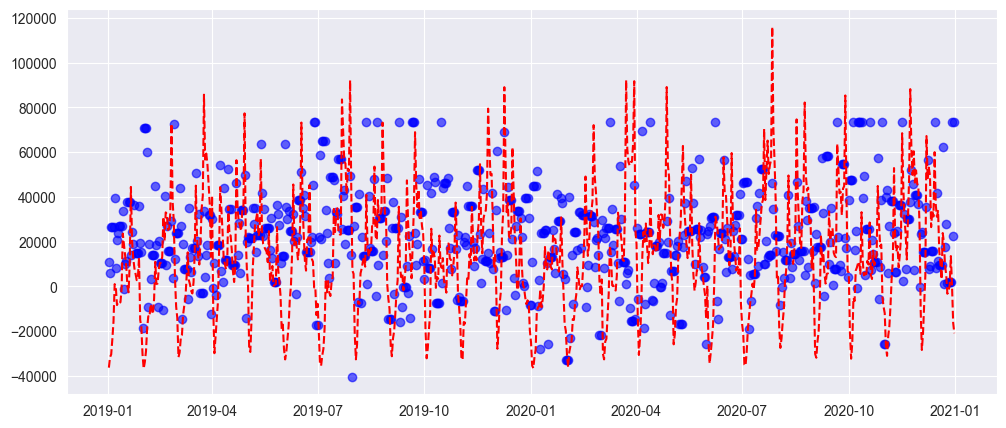

In [614]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(data_test.index, data_test["TransactionAmount"], color='blue', label="Actual Data", alpha=0.6)
ax.plot(data_test.index, data_test_predict["yhat_original"], color='red', linestyle='dashed', label="Predicted")
plt.show()

In [615]:
data_test_predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,yhat_original
0,2019-01-02,10.681008,6.180614,10.400796,10.681008,10.681008,-2.366531,-2.366531,-2.366531,-1.706890,...,-0.031797,-0.031797,-0.627845,-0.627845,-0.627845,0.0,0.0,0.0,8.314477,-36335.831800
1,2019-01-03,10.681185,6.847134,11.326117,10.681185,10.681185,-1.605644,-1.605644,-1.605644,-0.951175,...,-0.048041,-0.048041,-0.606427,-0.606427,-0.606427,0.0,0.0,0.0,9.075541,-31679.464566
2,2019-01-04,10.681362,6.991625,11.602694,10.681362,10.681362,-1.473110,-1.473110,-1.473110,-0.733373,...,-0.161707,-0.161707,-0.578030,-0.578030,-0.578030,0.0,0.0,0.0,9.208252,-30439.241075
3,2019-01-05,10.681539,7.694714,11.869226,10.681539,10.681539,-0.951339,-0.951339,-0.951339,-0.286000,...,-0.121654,-0.121654,-0.543686,-0.543686,-0.543686,0.0,0.0,0.0,9.730200,-23600.462688
4,2019-01-06,10.681717,7.953607,12.219968,10.681717,10.681717,-0.564745,-0.564745,-0.564745,-0.006921,...,-0.053269,-0.053269,-0.504555,-0.504555,-0.504555,0.0,0.0,0.0,10.116972,-15658.701138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2020-12-27,10.809514,8.365065,12.744555,10.809496,10.809531,-0.185583,-0.185583,-0.185583,0.459432,...,-0.053269,-0.053269,-0.591746,-0.591746,-0.591746,0.0,0.0,0.0,10.623931,688.497183
726,2020-12-28,10.809691,8.776477,12.887252,10.809674,10.809709,0.086106,0.086106,0.086106,0.364573,...,0.340536,0.340536,-0.619002,-0.619002,-0.619002,0.0,0.0,0.0,10.895797,13530.756967
727,2020-12-29,10.809868,8.567058,12.776178,10.809851,10.809886,-0.189332,-0.189332,-0.189332,0.371709,...,0.075932,0.075932,-0.636973,-0.636973,-0.636973,0.0,0.0,0.0,10.620536,549.190534
728,2020-12-30,10.810045,7.938263,12.104277,10.810028,10.810063,-0.718505,-0.718505,-0.718505,-0.041114,...,-0.031797,-0.031797,-0.645595,-0.645595,-0.645595,0.0,0.0,0.0,10.091540,-16280.444487


In [616]:
data_test

,TransactionAmount,TransactionAmount_shifted,TransactionAmount_log
Report_TransactionEffectiveDate,,,
2019-01-02,11085.985373,51504.365946,10.849441
2019-01-03,5997.282482,46415.663056,10.745414
2019-01-04,26741.238955,67159.619528,11.114842
2019-01-05,26741.238955,67159.619528,11.114842
2019-01-06,26741.238955,67159.619528,11.114842
...,...,...,...
2020-12-27,1763.692730,42182.073304,10.649774
2020-12-28,1763.692730,42182.073304,10.649774
2020-12-29,73263.818051,113682.198625,11.641171


In [617]:
np.sqrt(mean_squared_error(y_true=data_test["TransactionAmount"], y_pred = data_test_predict["yhat_original"]))

32630.225148410704

In [618]:
mean_absolute_error(y_true=data_test['TransactionAmount'],
                   y_pred=data_test_predict['yhat_original'])

25159.592620613108

In [619]:
mean_absolute_percentage_error(y_true=data_test['TransactionAmount'],
                   y_pred=data_test_predict['yhat_original'])

267.7082811512271

In [620]:
last_date_in_test = data_test.index[-1]
last_date_in_test

Timestamp('2020-12-31 00:00:00')

In [621]:
future = pd.date_range(start=last_date_in_test + pd.Timedelta(days=1), periods=90, freq='D')
future_df = pd.DataFrame({'ds': future}) 

forecast_future = model.predict(future_df)
forecast_future

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,10.810400,7.536520,11.693205,10.810400,10.810400,-1.223392,-1.223392,-1.223392,-0.426027,...,-0.161707,-0.161707,-0.161707,-0.635657,-0.635657,-0.635657,0.0,0.0,0.0,9.587008
1,2021-01-02,10.810577,6.417365,10.743232,10.810577,10.810577,-2.305356,-2.305356,-2.305356,-1.565635,...,-0.121654,-0.121654,-0.121654,-0.618067,-0.618067,-0.618067,0.0,0.0,0.0,8.505222
2,2021-01-03,10.810754,6.358195,10.554024,10.810754,10.810754,-2.353198,-2.353198,-2.353198,-1.706890,...,-0.053269,-0.053269,-0.053269,-0.593040,-0.593040,-0.593040,0.0,0.0,0.0,8.457556
3,2021-01-04,10.810932,7.469564,11.841483,10.810932,10.810932,-1.172171,-1.172171,-1.172171,-0.951175,...,0.340536,0.340536,0.340536,-0.561531,-0.561531,-0.561531,0.0,0.0,0.0,9.638760
4,2021-01-05,10.811109,7.512671,11.966054,10.811109,10.811109,-1.182082,-1.182082,-1.182082,-0.733373,...,0.075932,0.075932,0.075932,-0.524642,-0.524642,-0.524642,0.0,0.0,0.0,9.629027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2021-03-27,10.825466,9.210474,13.611934,10.825466,10.825467,0.649490,0.649490,0.649490,0.374893,...,-0.121654,-0.121654,-0.121654,0.396251,0.396251,0.396251,0.0,0.0,0.0,11.474956
86,2021-03-28,10.825643,9.660894,13.801203,10.825643,10.825644,0.843288,0.843288,0.843288,0.468514,...,-0.053269,-0.053269,-0.053269,0.428042,0.428042,0.428042,0.0,0.0,0.0,11.668931
87,2021-03-29,10.825821,9.933237,14.131637,10.825820,10.825821,1.192006,1.192006,1.192006,0.398849,...,0.340536,0.340536,0.340536,0.452622,0.452622,0.452622,0.0,0.0,0.0,12.017827
88,2021-03-30,10.825998,9.555461,13.884895,10.825997,10.825998,0.930701,0.930701,0.930701,0.385359,...,0.075932,0.075932,0.075932,0.469410,0.469410,0.469410,0.0,0.0,0.0,11.756699


In [622]:
forecast_future['yhat_original'] = np.exp(forecast_future['yhat']) - shift
forecast_future

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,yhat_original
0,2021-01-01,10.810400,7.536520,11.693205,10.810400,10.810400,-1.223392,-1.223392,-1.223392,-0.426027,...,-0.161707,-0.161707,-0.635657,-0.635657,-0.635657,0.0,0.0,0.0,9.587008,-25844.183110
1,2021-01-02,10.810577,6.417365,10.743232,10.810577,10.810577,-2.305356,-2.305356,-2.305356,-1.565635,...,-0.121654,-0.121654,-0.618067,-0.618067,-0.618067,0.0,0.0,0.0,8.505222,-35477.882083
2,2021-01-03,10.810754,6.358195,10.554024,10.810754,10.810754,-2.353198,-2.353198,-2.353198,-1.706890,...,-0.053269,-0.053269,-0.593040,-0.593040,-0.593040,0.0,0.0,0.0,8.457556,-35707.848350
3,2021-01-04,10.810932,7.469564,11.841483,10.810932,10.810932,-1.172171,-1.172171,-1.172171,-0.951175,...,0.340536,0.340536,-0.561531,-0.561531,-0.561531,0.0,0.0,0.0,9.638760,-25070.073102
4,2021-01-05,10.811109,7.512671,11.966054,10.811109,10.811109,-1.182082,-1.182082,-1.182082,-0.733373,...,0.075932,0.075932,-0.524642,-0.524642,-0.524642,0.0,0.0,0.0,9.629027,-25218.748495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2021-03-27,10.825466,9.210474,13.611934,10.825466,10.825467,0.649490,0.649490,0.649490,0.374893,...,-0.121654,-0.121654,0.396251,0.396251,0.396251,0.0,0.0,0.0,11.474956,55855.814337
86,2021-03-28,10.825643,9.660894,13.801203,10.825643,10.825644,0.843288,0.843288,0.843288,0.468514,...,-0.053269,-0.053269,0.428042,0.428042,0.428042,0.0,0.0,0.0,11.668931,76464.914152
87,2021-03-29,10.825821,9.933237,14.131637,10.825820,10.825821,1.192006,1.192006,1.192006,0.398849,...,0.340536,0.340536,0.452622,0.452622,0.452622,0.0,0.0,0.0,12.017827,125263.846589
88,2021-03-30,10.825998,9.555461,13.884895,10.825997,10.825998,0.930701,0.930701,0.930701,0.385359,...,0.075932,0.075932,0.469410,0.469410,0.469410,0.0,0.0,0.0,11.756699,87187.140225


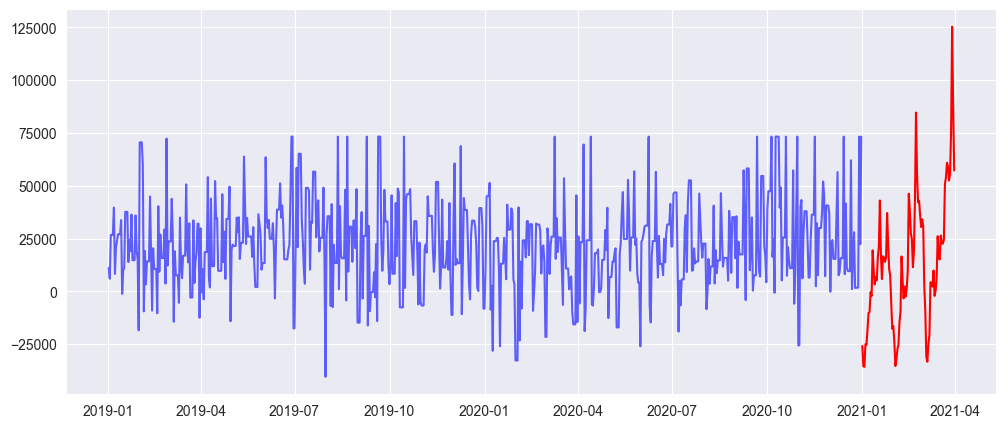

In [623]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(data_test.index, data_test["TransactionAmount"], color='blue', label="Actual Data", alpha=0.6)
ax.plot(forecast_future['ds'], forecast_future["yhat_original"], color='red', label="Predicted")
plt.show()

In [624]:
export_df = pd.DataFrame({
    'GroupName': 'Precision Analyst',
    'Date': forecast_future['ds'].dt.date,
    'TotalPredictedAmount': forecast_future['yhat_original']
})

# Round the predicted amounts to 2 decimal places
export_df['TotalPredictedAmount'] = export_df['TotalPredictedAmount'].round(2)

# Export to Excel
export_df.to_excel('forecast_results_prophet_2.xlsx', index=False)

# Display the first few rows of the exported data
print("Preview of exported data:")
print(export_df.head())

Preview of exported data:
           GroupName        Date  TotalPredictedAmount
0  Precision Analyst  2021-01-01             -25844.18
1  Precision Analyst  2021-01-02             -35477.88
2  Precision Analyst  2021-01-03             -35707.85
3  Precision Analyst  2021-01-04             -25070.07
4  Precision Analyst  2021-01-05             -25218.75
